<a href="https://colab.research.google.com/github/pingwx/ya.prac/blob/main/10_Linear_algebra/10_RU_Linear_algebra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Защита персональных данных клиентов

Заказчик - страховая компания "Хоть потоп" столкнулся с проблемой защиты данных своих клиентов. Он просит разработать метод преобразования данных, по которому невозможно было бы восстановить исходные данные клиентов. При этом качество модели, используемой заказчиком для предсказаний, не должно стать хуже. Известно, что заказчиком используется модель линейной регрессии.
Необходимо обосновать корректность разработанного метода.

## Загрузка данных

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np

In [3]:
df = pd.read_csv('/content/insurance.csv')

In [4]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


Данные загрузили, посмотрели на первые строки таблицы.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Посмотрели на типы столбцов, убедились что нет пропусков.

In [6]:
df.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


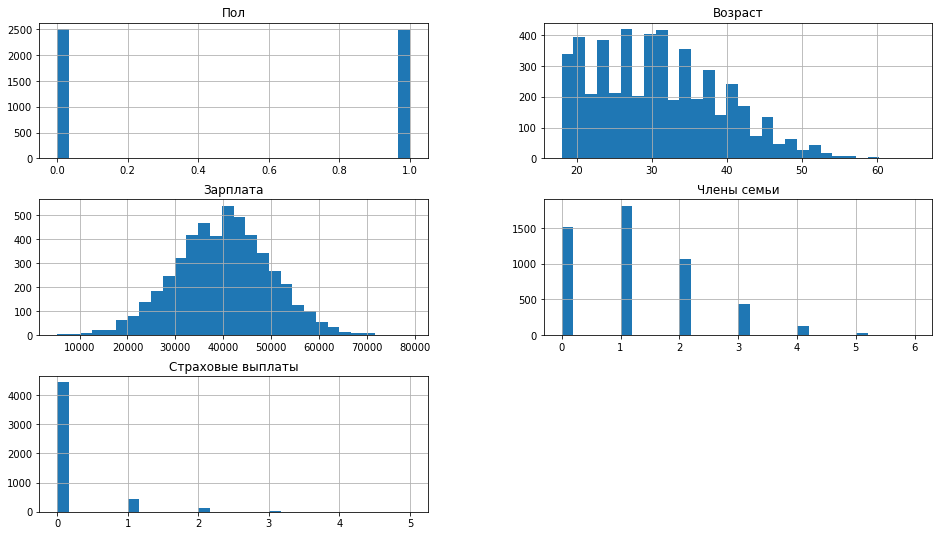

In [7]:
df.hist(figsize=(16,9), bins=30);

Посмотрели на распределения признаков и целевого признака

In [8]:
df.columns = ['sex', 'age', 'salary', 'family_count', 'insurance_count']

Переименовали столбцы

## Умножение матриц

Ответим на следующий вопрос: признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? Из определения обратимой матрицы известно, что обратимая матрица является квадратной. Если исходная матрица признаков $X$ имеет размер $(n\times m)$, то матрица $P$, на которую домножается $X$ имеет единственно возможный размер $(m\times m)$. Проведем эксперимент и посмотрим, что получится. Сначала обучим модель на исходных признаках.

In [9]:
X = df.drop('insurance_count', axis=1).values
y = df['insurance_count'].values
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.25,
                                                      random_state=1)
model = LinearRegression()
model.fit(X_train, y_train)
predict = model.predict(X_valid)
r2 = r2_score(y_valid, predict)
r2

0.32377322792427543

Теперь возьмем некоторую матрицу $P$

In [10]:
P = np.random.randint(100, size=(X_train.shape[1], (X_train.shape[1])))
P

array([[ 0, 34, 32,  3],
       [45, 81, 79, 50],
       [68, 31, 37, 33],
       [49, 61, 66, 66]])

Убедимся, что $P$ обратима.

In [11]:
np.linalg.inv(P)

array([[-0.02210436,  0.01957876,  0.01831059, -0.02298295],
       [-0.2181123 ,  0.2252807 , -0.05197091, -0.13476755],
       [ 0.26764896, -0.24107913,  0.0573687 ,  0.14178549],
       [-0.04964951,  0.0183294 , -0.02292921,  0.01498701]])

Обучим снова модель, домножив $X$ на $P$

In [12]:
model = LinearRegression()
model.fit(X_train@P, y_train)
predict = model.predict(X_valid@P)
r2 = r2_score(y_valid, predict)
r2

0.3237732279247376

Мы получили R2 практически такой же, как для модели, обученной на исходных признаках с точностью до далеких знаков после запятой. Наше предположение следующее: домножение матрицы признаков $X$ на обратимую матрицу $P$ не влияет на предсказание модели. Попробуем установить, так ли это. Для этого воспользуемся свойствами транспонированных и обратных матриц __[отсюда](https://ru.wikipedia.org/wiki/%D0%A2%D1%80%D0%B0%D0%BD%D1%81%D0%BF%D0%BE%D0%BD%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%BD%D0%B0%D1%8F_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0)__ и __[отсюда](https://ru.wikipedia.org/wiki/%D0%9E%D0%B1%D1%80%D0%B0%D1%82%D0%BD%D0%B0%D1%8F_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0)__, а именно $(AB)^T = B^TA^T$; $(AB)^{-1} = B^{-1}A^{-1}$.

Известно, что предсказания модели линейной регрессии записываются как $a = Xw$, где $X$ - матрица признаков, $w$ - вектор весов линейной регрессии. Известно, что

$$
w = (X^T X)^{-1} X^T y
$$
где $y$ - вектор целевого признака. Пусть $X'$ = $XP$, исходная матрица $X$, домноженная на некоторую обратимую матрицу $P$. Тогда $w' = (X'^T X')^{-1} X'^T y$; $a'=X'w'$. Посмотрим, как соотносятся предсказания $a$ и $a'$

$$
w' = (X'^T X')^{-1} X'^T y = ((XP)^TXP)^{-1}(XP)^Ty =
$$
$$
= P^{-1}((XP)^TX)^{-1}(XP)^Ty = P^{-1}(P^TX^TX)^{-1}P^TX^Ty =
$$
$$
= P^{-1}(X^TX)^{-1}(P^T)^{-1}P^TX^Ty = P^{-1}(X^TX)^{-1}X^Ty
$$

Тогда

$$
a'=X'w'=XPP^{-1}(X^TX)^{-1}X^Ty = X(X^TX)^{-1}X^Ty =
$$
$$
= Xw = a
$$

Таким образом мы убедились, что предсказания $a$ и $a'$ равны и наше предположение о том, что домножение $X$ на $P$ не влияет на предсказание модели линейной регрессии оказалось верным.

## Алгоритм преобразования

Исходя из сказанного выше, алгоритм преобразования для защиты данных клиентов описывается так. Персональные данные, которые представляют из себя матрицу принзаков $X$ домножим на некоторую обратимую матрицу $P$, которую будем держать в секрете. Модель линейной регрессии обучается на преобразованных данных. В момент использования модели для предсказания, данные, для которых предсказание нужно сделать, также домножаются на секретную матрицу $P$. По причинам описанным выше, качество линейной регрессии останется неизменным, а исходные данные защищены.

## Проверка алгоритма

Алгоритм уже, по сути, проверен в п.2. Работа выполнена в таком порядке по следующей причине. Для ответа на вопрос в п.2 инструкций к проекту проще было написать несколько строк кода и посмотреть на результат. Видя одинаковый R2 скор для исходных и преобразованных признаков, очевидным образом напрашивается предположение, что домножение $X$ на $P$ не влияет на результат. Это предположение было проверено при помощи листка и ручки, а затем перенесено сюда.